In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
today = '200609'

# Grid search for Kuramoto-Sivashinsky prediction

We perform the grid search on Structured Reservoir Computing as it is the most efficient method for our case. We run it on a time series of length 10,000 for training and 4,000 for testing. The reservoir size is about 8,000.

Here are the hyperparameters to tune:
- input_scale: scale of the input weights
- res_scale: scale of the reservoir weights
- bias_scale: scale of the random additive bias
- renorm_factor: scale of the current input, that is concatenated with the reservoir state
- alpha: L2 regularization factor
Since there is a lot of hyperparameters to vary, we perform grid searches on each of them successively.

## Data generation

In [3]:
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 5000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)

## Grid search

In [4]:
test_len = 4000
n_rec_pred = test_len
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_res = 8192-input_dim
input_scale = 0.4
res_scale = 0.9
bias_scale = 0.4
renorm_factor = 1.1 * np.sqrt(input_dim / n_res)
alpha = 1e-2
leak_rate = 1

## Choose here the parameter for the grid search
input_scale_vec = np.arange(start=0.1, stop=1.01, step=0.1)
# res_scale_vec = np.arange(start=0.1, stop=1.01, step=0.1)
# bias_scale_vec = np.arange(start=0.1, stop=1.01, step=0.1)
# renorm_factor_vec = np.arange(start=0.1, stop=1.51, step=0.1)
# renorm_factor_vec = [renorm_factor * np.sqrt(input_dim / n_res) for renorm_factor in renorm_factor_vec]
# alpha_vec = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

## Change here the parameter of the grid search to vary
err = torch.zeros(len(input_scale_vec))
for i, input_scale in tqdm(enumerate(input_scale_vec)):
    try:
        bias = bias_scale * torch.randn(n_res).to(device)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', leak_rate=leak_rate, bias=bias, random_projection='structured')
        X = model.forward(u_train_t).to(device)
        X = torch.cat((X, u_train_t*renorm_factor), dim=1)

        output_w = model.train(X, out_train, alpha=alpha)

        Xtest = model.forward(u_test_t[:test_len]).to(device)

        n_rec = 400
        test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)

        new_pred_horizon = pred_horizon_range * (n_rec+1)
        out_test = torch.zeros(test_len, input_dim * new_pred_horizon).to(device)
        for pred_horizon in range(1, new_pred_horizon+1):
            out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)[:test_len]

        rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
        truth = out_test[:n_rec_pred, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
        diff = rec_pred - truth
        err[i] = torch.sqrt(torch.mean(diff**2))

        del X, Xtest, model, bias, output_w, test_rec_pred, out_test, rec_pred, truth, diff
        torch.cuda.empty_cache()
    except:
        pass

10it [01:25,  8.55s/it]


tensor([0.7406, 0.1502, 0.1447, 0.1448, 0.1463, 0.1520, 0.1535, 0.1536, 0.1557,
        0.1572])
tensor(2)


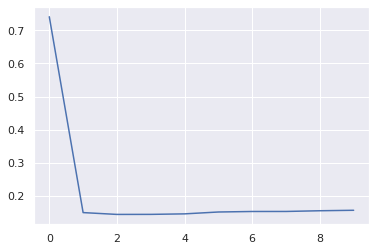

In [5]:
print(err)
print(np.argmin(err.cpu()))
plt.plot(err);